In [1]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', 500)
import pandas as pd
train = pd.read_csv("train.csv")

In [3]:
train = train.iloc[:, 2:]
train.head()

,Timestamp,Values,Temperature,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,tv delta,prev value,twice prev value,day shift,month shift,year,pred
0,2012-01-31 06:00:00+00:00,11213381.0,0.3,0,1,6,1,31,1.0,224.0,224.0,203.0,215.0,205.0,97.0,2012,216.70
1,2012-01-31 07:00:00+00:00,11213635.0,0.2,0,1,7,1,31,1.0,254.0,254.0,224.0,203.0,242.0,107.0,2012,242.11
2,2012-01-31 08:00:00+00:00,11213893.0,0.2,0,1,8,1,31,1.0,258.0,258.0,254.0,224.0,248.0,106.0,2012,257.67
3,2012-01-31 09:00:00+00:00,11214154.0,0.2,0,1,9,1,31,1.0,261.0,261.0,258.0,254.0,242.0,95.0,2012,260.36
4,2012-01-31 10:00:00+00:00,11214422.0,0.4,0,1,10,1,31,1.0,268.0,268.0,261.0,258.0,234.0,103.0,2012,262.94


In [4]:
X = train[['Timestamp', 'tv delta', 'Temperature', 'holiday', 'month shift', 'Weekday', 'Hour', 'Month', 'Day']]
X.rename({'tv delta': 'consumption'}, axis=1, inplace= True)


C:\Users\sarit.maitra\AppData\Local\Temp\ipykernel_640\4166363925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename({'tv delta': 'consumption'}, axis=1, inplace= True)


In [5]:
# Filter out extreme values
X_clean = X[(X['month shift'] != -5095) & (X['month shift'] != 5095)]
X_clean.set_index('Timestamp', inplace=True)

In [6]:
X_clean.head(2)

,consumption,Temperature,holiday,month shift,Weekday,Hour,Month,Day
Timestamp,,,,,,,,
2012-01-31 06:00:00+00:00,224.0,0.3,0,97.0,1,6,1,31
2012-01-31 07:00:00+00:00,254.0,0.2,0,107.0,1,7,1,31


In [7]:
test = pd.read_csv("test.csv")
test = test.iloc[:, 2:]
test.rename({'tv delta': 'consumption'}, axis=1, inplace= True)
test = test[['Timestamp', 'consumption', 'Temperature', 'holiday', 'month shift',
       'Weekday', 'Hour', 'Month', 'Day']]
test.set_index('Timestamp', inplace=True)
test.head(2)

,consumption,Temperature,holiday,month shift,Weekday,Hour,Month,Day
Timestamp,,,,,,,,
2016-01-01 00:00:00+00:00,41.0,5.0,1,123.0,4,0,1,1
2016-01-01 01:00:00+00:00,43.0,5.0,1,125.0,4,1,1,1


In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# Define features and target variable
x = X_clean[['Temperature', 'holiday', 'month shift',
       'Weekday', 'Hour', 'Month', 'Day']]
y = X_clean['consumption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

model = IsolationForest(random_state=47)

param_grid = {'n_estimators': list(range(100, 800, 5)),
              'max_samples': list(range(100, 500, 5)),
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_features': [5,10,15],
              'bootstrap': [True, False],
              'n_jobs': [5, 10, 20, 30]}

grid_search = model_selection.GridSearchCV(model,
                                           param_grid,
                                           scoring="neg_mean_squared_error",
                                           refit=True,
                                           cv=10,
                                           return_train_score=True)
grid_search.fit(X_train, y_train)

In [ ]:
best_model = grid_search.fit(X_train, y_train)
print('Optimum parameters', best_model.best_params_)

## CNN

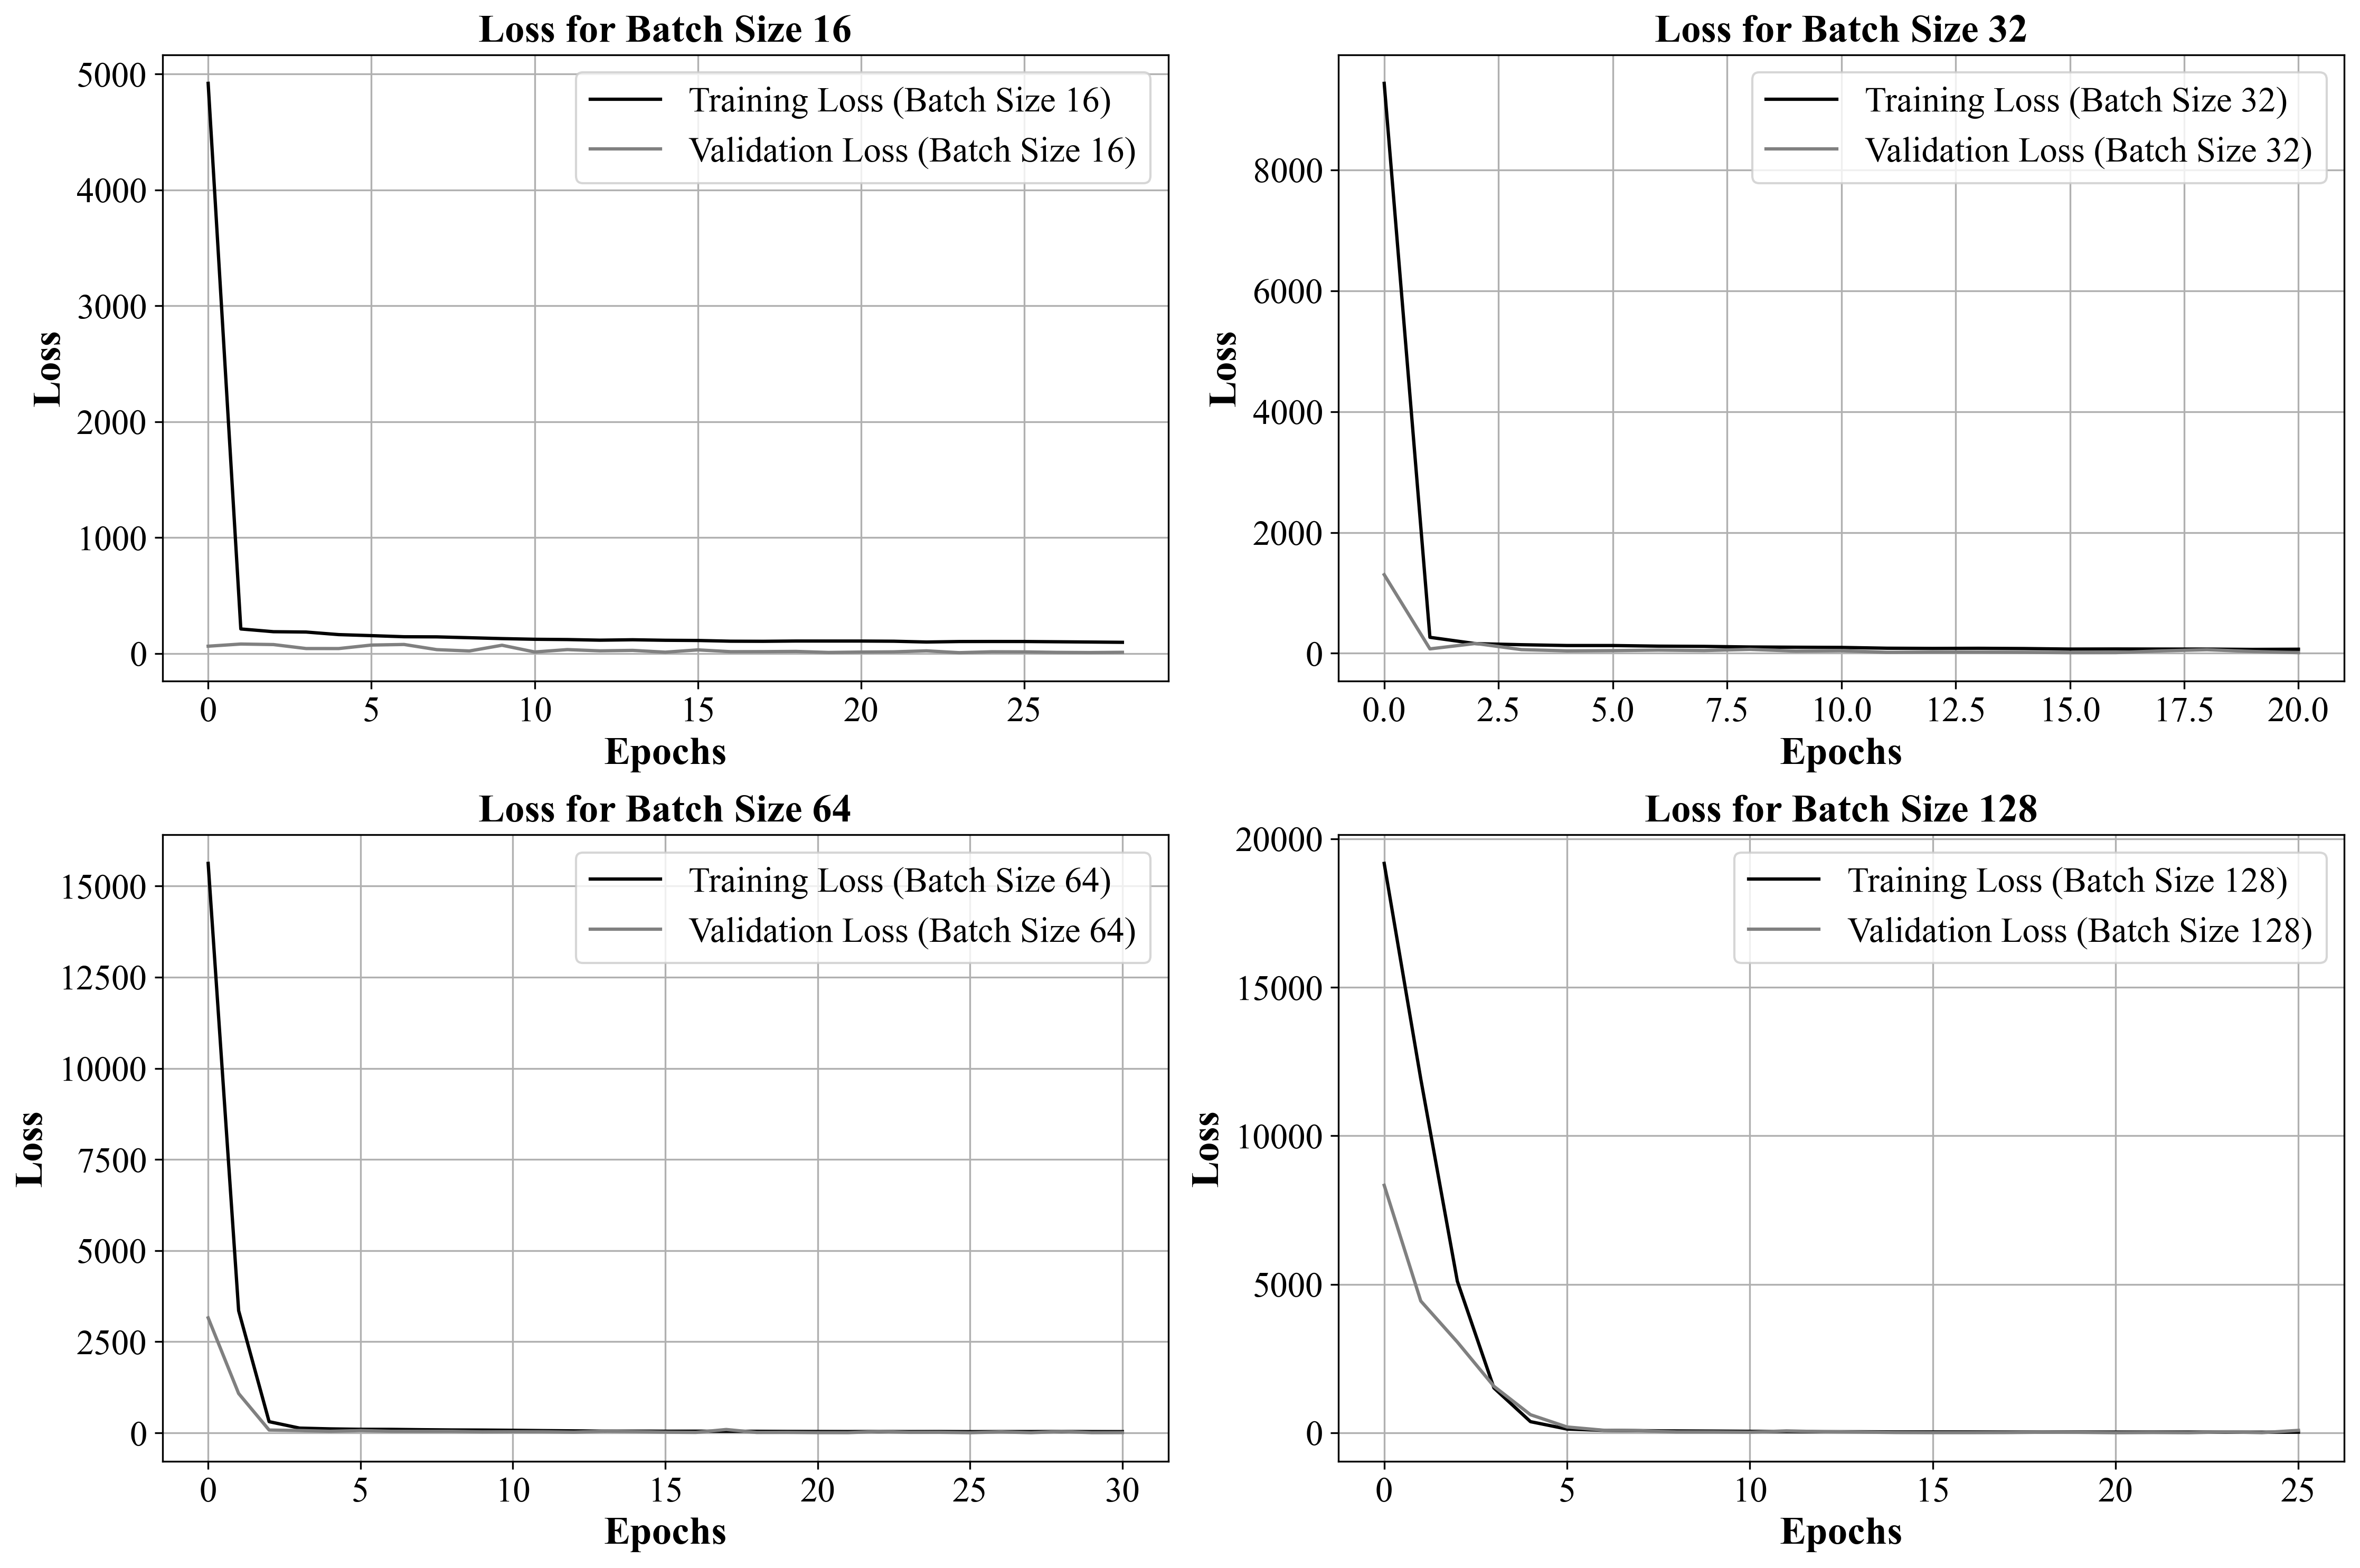

In [31]:
# # Instantiate StandardScaler
# scaler = StandardScaler()

# # Fit the scaler on the consumption data
# scaler.fit(X_clean[['consumption']])

# # Normalize the consumption data using the fitted scaler
# x_train_normalized = scaler.transform(X_clean[['consumption']])


# # Calculate mean and standard deviation
# mean = X_clean['consumption'].mean()
# std_dev = X_clean['consumption'].std()

# # Normalize the data using mean and standard deviation
# x_train_normalized = (X_clean['consumption'] - mean) / std_dev

# Define the time steps for creating sequences
TIME_STEPS = 24

# Function to create sequences
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# Create sequences from the normalized data
x_train = create_sequences(X_clean['consumption'])

# Reshape the data to match the input shape of the model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

batch_sizes = [16, 32, 64, 128]

# Create subplots
fig, axs = plt.subplots(2, len(batch_sizes)//2, figsize=(15, 10), dpi=300)

for i, batch_size in enumerate(batch_sizes):
    row = i // (len(batch_sizes)//2)
    col = i % (len(batch_sizes)//2)
    
    # Define the autoencoder model
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Conv1D(filters=8, kernel_size=7, padding="same", strides=2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=8, kernel_size=7, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    # Train the model
    history = model.fit(
        x_train,
        x_train,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
        verbose=0  # Set verbose to 0 to suppress training output
    )

    # Plot the training and validation loss
    axs[row, col].plot(history.history["loss"], label="Training Loss (Batch Size {})".format(batch_size), color ='k')
    axs[row, col].plot(history.history["val_loss"], label="Validation Loss (Batch Size {})".format(batch_size), color='gray')
    axs[row, col].set_xlabel('Epochs', fontsize=18, fontweight='bold')
    axs[row, col].set_ylabel('Loss', fontsize=18, fontweight='bold')
#     axs[row, col].set_title("Loss for Batch Size {}".format(batch_size), fontsize=18, fontweight='bold')
    axs[row, col].legend(fontsize=18)

# Set tick parameters for all subplots
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)

plt.tight_layout()
plt.show()

## Auto encoder + CNN

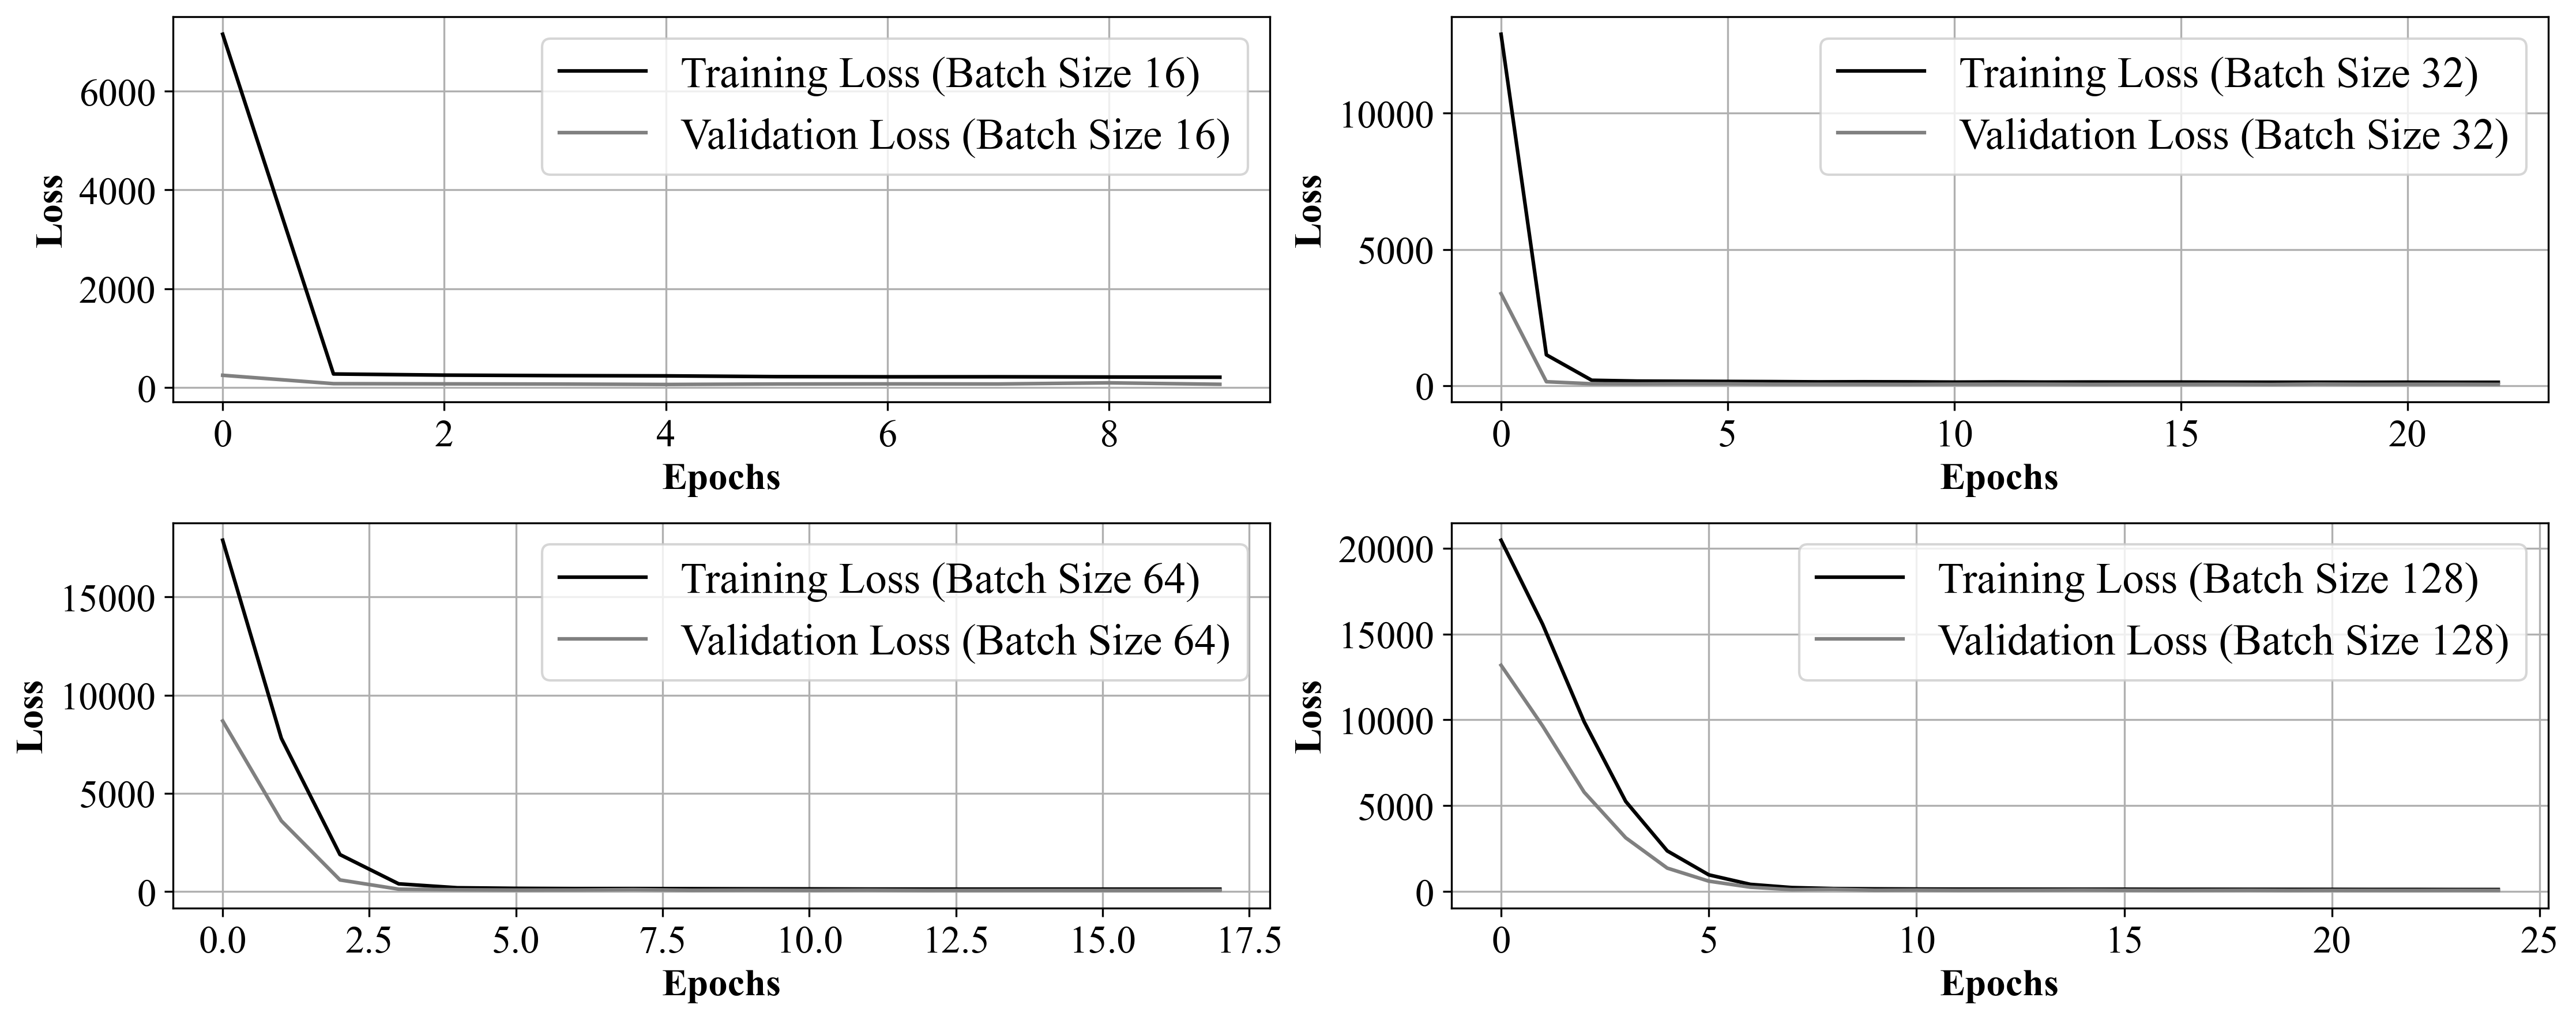

In [127]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the time steps for creating sequences
TIME_STEPS = 24

# Function to create sequences
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(X_clean['consumption'])

# Reshape the data to match the input shape of the model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

batch_sizes = [16, 32, 64, 128]

# Create subplots
fig, axs = plt.subplots(2, len(batch_sizes)//2, figsize=(15, 6), dpi=300)

for i, batch_size in enumerate(batch_sizes):
    row = i // (len(batch_sizes)//2)
    col = i % (len(batch_sizes)//2)

    # Define the autoencoder model
    def build_autoencoder():
        input_seq = keras.Input(shape=(TIME_STEPS, 1))

        # Encoder
        encoder = layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(input_seq)
        encoder = layers.BatchNormalization()(encoder)
        encoder = layers.Conv1D(filters=8, kernel_size=7, padding="same", strides=2, activation="relu")(encoder)
        encoder = layers.BatchNormalization()(encoder)

        # Latent space
        latent_space = layers.Conv1D(filters=4, kernel_size=7, padding="same", strides=2, activation="relu")(encoder)

        # Decoder
        decoder = layers.Conv1DTranspose(filters=8, kernel_size=7, padding="same", strides=2, activation="relu")(latent_space)
        decoder = layers.BatchNormalization()(decoder)
        decoder = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(decoder)
        decoder = layers.BatchNormalization()(decoder)

        # Output sequence length matches input sequence length
        output_seq = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", strides=2)(decoder)

        # Autoencoder model
        autoencoder = keras.Model(input_seq, output_seq)
        return autoencoder

    # Build the autoencoder
    autoencoder = build_autoencoder()


    # Compile the model
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    # Train the model
    history = autoencoder.fit(
        x_train,
        x_train,
        epochs=50,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
        verbose=0  # Set verbose to 0 to suppress training output
    )

    # Plot the training and validation loss
    axs[row, col].plot(history.history["loss"], label="Training Loss (Batch Size {})".format(batch_size), color ='k')
    axs[row, col].plot(history.history["val_loss"], label="Validation Loss (Batch Size {})".format(batch_size), color='gray')
    axs[row, col].set_xlabel('Epochs', fontsize=16, fontweight='bold')
    axs[row, col].set_ylabel('Loss', fontsize=16, fontweight='bold')
#     axs[row, col].set_title("Loss for Batch Size {}".format(batch_size), fontsize=14, fontweight='bold')
    axs[row, col].legend(fontsize=18)

# tick parameters for all subplots
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)

plt.tight_layout()
plt.show()

In [98]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# # Instantiate StandardScaler
# scaler = StandardScaler()

# # Fit the scaler on the consumption data
# scaler.fit(X_clean[['consumption']])

# # Normalize the consumption data using the fitted scaler
# x_train_normalized = scaler.transform(X_clean[['consumption']])


# Define the time steps for creating sequences
TIME_STEPS = 24

# Function to create sequences
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = X_clean['consumption'].values
x_train = create_sequences(x_train_normalized)

# Reshape the data to match the input shape of the model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

# Define the autoencoder model
def build_autoencoder():
    input_seq = keras.Input(shape=(TIME_STEPS, 1))

    # Encoder
    encoder = layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(input_seq)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Conv1D(filters=8, kernel_size=7, padding="same", strides=2, activation="relu")(encoder)
    encoder = layers.BatchNormalization()(encoder)

    # Latent space
    latent_space = layers.Conv1D(filters=4, kernel_size=7, padding="same", strides=2, activation="relu")(encoder)

    # Decoder
    decoder = layers.Conv1DTranspose(filters=8, kernel_size=7, padding="same", strides=2, activation="relu")(latent_space)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(decoder)
    decoder = layers.BatchNormalization()(decoder)

    # Output sequence length matches input sequence length
    output_seq = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", strides=2)(decoder)

    # Autoencoder model
    autoencoder = keras.Model(input_seq, output_seq)
    return autoencoder

# Build the autoencoder
autoencoder = build_autoencoder()

# Compile the model
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Train the model
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
    verbose=0  # Set verbose to 0 to suppress training output
)


In [99]:
# Calculate Reconstruction Error
x_test = create_sequences(test['consumption'].values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

x_test_pred = autoencoder.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# Flatten the test_mae_loss array
test_mae_loss_flat = test_mae_loss.flatten()

# Create a Pandas Series with the correct index
test_mae_loss_series = pd.Series(test_mae_loss_flat, index=test.index[:len(test_mae_loss_flat)])

494/494 [==============================] - 1s 2ms/step


494/494 [==============================] - 1s 2ms/step


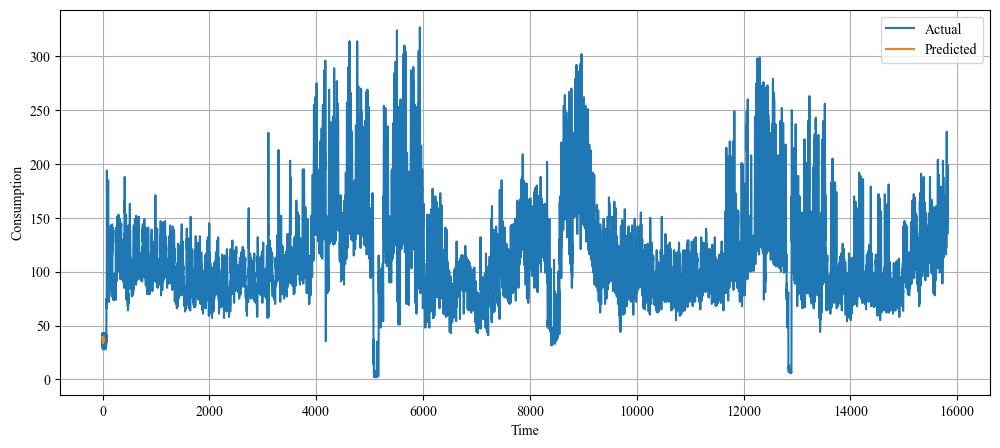

In [100]:
# Use the model to predict consumption values
predictions = autoencoder.predict(x_test)

predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

# Choose the sequence index for plotting (e.g., the first sequence)
sequence_index = 0

# Plot the original test data and the predictions for the chosen sequence
plt.figure(figsize=(12, 5))
plt.plot(test.consumption.values, label='Actual')
plt.plot(predictions[sequence_index], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

Epoch 1/10
467/467 [==============================] - 6s 5ms/step - loss: 0.1862 - val_loss: 0.0448
Epoch 2/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0975 - val_loss: 0.0356
Epoch 3/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0839 - val_loss: 0.0393
Epoch 4/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0747 - val_loss: 0.0461
Epoch 5/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0694 - val_loss: 0.0307
Epoch 6/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0633 - val_loss: 0.0319
Epoch 7/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0629 - val_loss: 0.0282
Epoch 8/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0581 - val_loss: 0.0250
Epoch 9/10
467/467 [==============================] - 2s 5ms/step - loss: 0.0580 - val_loss: 0.0301
Epoch 10/10
1036/1036 [==============================] - 2s 2ms/step


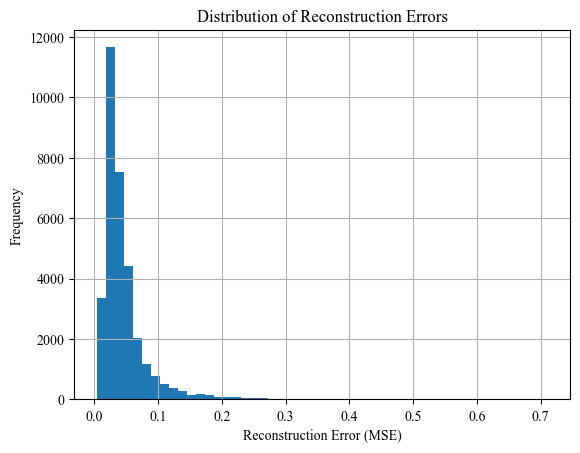

In [101]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# Assuming x_train is your input data with shape (num_samples, time_steps, num_features)

# Define the autoencoder model
def build_autoencoder(input_shape):
    input_seq = keras.Input(shape=input_shape)

    # Encoder
    encoder = layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(input_seq)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Conv1D(filters=8, kernel_size=7, padding="same", strides=2, activation="relu")(encoder)
    encoder = layers.BatchNormalization()(encoder)

    # Latent space
    latent_space = layers.Conv1D(filters=4, kernel_size=7, padding="same", strides=2, activation="relu")(encoder)

    # Decoder
    decoder = layers.Conv1DTranspose(filters=8, kernel_size=7, padding="same", strides=2, activation="relu")(latent_space)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(decoder)
    decoder = layers.BatchNormalization()(decoder)

    # Output sequence length matches input sequence length
    output_seq = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same", strides=2)(decoder)

    # Autoencoder model
    autoencoder = keras.Model(input_seq, output_seq)
    return autoencoder

# Build the autoencoder
input_shape = x_train.shape[1:]  # Assuming x_train is your input data
autoencoder = build_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Train the model
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1
)

# Generate reconstructed sequences
reconstructed_sequences = autoencoder.predict(x_train)


# Calculate reconstruction error (MSE) for each input sequence
reconstruction_errors = np.mean(np.square(x_train - reconstructed_sequences), axis=(1, 2))

# Plot the reconstruction error distribution
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()


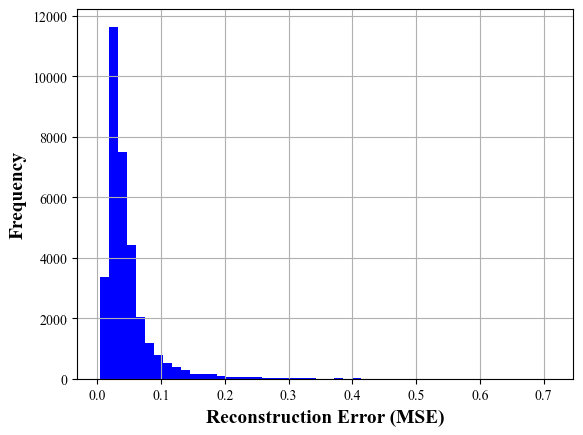

In [102]:
# Plot the reconstruction error distribution
plt.hist(reconstruction_errors, color= 'blue',bins=50)
plt.xlabel('Reconstruction Error (MSE)', fontsize = 14, fontweight='bold')
plt.ylabel('Frequency', fontsize = 14, fontweight='bold')
# plt.title('Distribution of Reconstruction Errors')
plt.show()

In [103]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score


# Flatten the actual values and predictions for ease of calculation
actual_values_flat = test['consumption'].values.flatten()
predictions_flat = predictions.flatten()

# Ensure both arrays have the same length
min_length = min(len(actual_values_flat), len(predictions_flat))
actual_values_flat = actual_values_flat[:min_length]
predictions_flat = predictions_flat[:min_length]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values_flat, predictions_flat)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values_flat, predictions_flat)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(actual_values_flat, predictions_flat)

# Calculate R-squared (R2) score
r2 = r2_score(actual_values_flat, predictions_flat)

# Print the error metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Coefficient of Determination (R^2 Score):", r2)


Mean Absolute Error (MAE): 41.652796724674936
Mean Squared Error (MSE): 3026.0238385033313
Root Mean Squared Error (RMSE): 55.009306835328616
Mean Absolute Percentage Error (MAPE): 0.5035409146462803
Coefficient of Determination (R^2 Score): -0.6055159377005748


In [104]:
# Calculate Mahalanobis Distance for Multivariate Data
def mahalanobis_distance_multivariate(x, mean_vector, cov_matrix):
    delta = x - mean_vector
    mahalanobis_dist = np.sqrt(np.dot(delta, np.dot(np.linalg.inv(cov_matrix), delta.T)))
    return mahalanobis_dist

# Extract relevant columns for computing Mahalanobis distance
relevant_columns = ['Temperature', 'holiday', 'month shift', 'Weekday', 'Hour', 'Month', 'Day']
x_test_multivariate = test[relevant_columns].values

# Compute mean and covariance matrix for multivariate data
mean_vector_multivariate = x_test_multivariate.mean(axis=0)
cov_matrix_multivariate = np.cov(x_test_multivariate, rowvar=False)

# Calculate Mahalanobis distance for each test sample
mahalanobis_distances_multivariate = []
for point in x_test_multivariate:
    mahalanobis_distances_multivariate.append(mahalanobis_distance_multivariate(point, mean_vector_multivariate, cov_matrix_multivariate))

# Convert to numpy array
mahalanobis_distances_multivariate = np.array(mahalanobis_distances_multivariate)

# Reshape the Mahalanobis distances array to match the shape of test_mae_loss_flat
mahalanobis_distances_flat = mahalanobis_distances_multivariate.flatten()

# Ensure that the shapes of both arrays match
if len(test_mae_loss_flat) != len(mahalanobis_distances_flat):
    # Adjust the lengths of the arrays to match
    min_length = min(len(test_mae_loss_flat), len(mahalanobis_distances_flat))
    test_mae_loss_flat = test_mae_loss_flat[:min_length]
    mahalanobis_distances_flat = mahalanobis_distances_flat[:min_length]

# Calculate combined score
combined_score_multivariate = test_mae_loss_flat + mahalanobis_distances_flat

# Set threshold for anomaly detection
threshold_percentage = 95  # Adjust as needed
threshold_multivariate = np.percentile(combined_score_multivariate, threshold_percentage)

# Identify anomalies based on the combined score
anomalies_combined_multivariate = (combined_score_multivariate > threshold_multivariate).astype(int)

# Display the number of anomalies
print("Number of anomalies detected (multivariate):", np.sum(anomalies_combined_multivariate))

Number of anomalies detected (multivariate): 791


Number of anomalies (Dynamic Threshold): 596


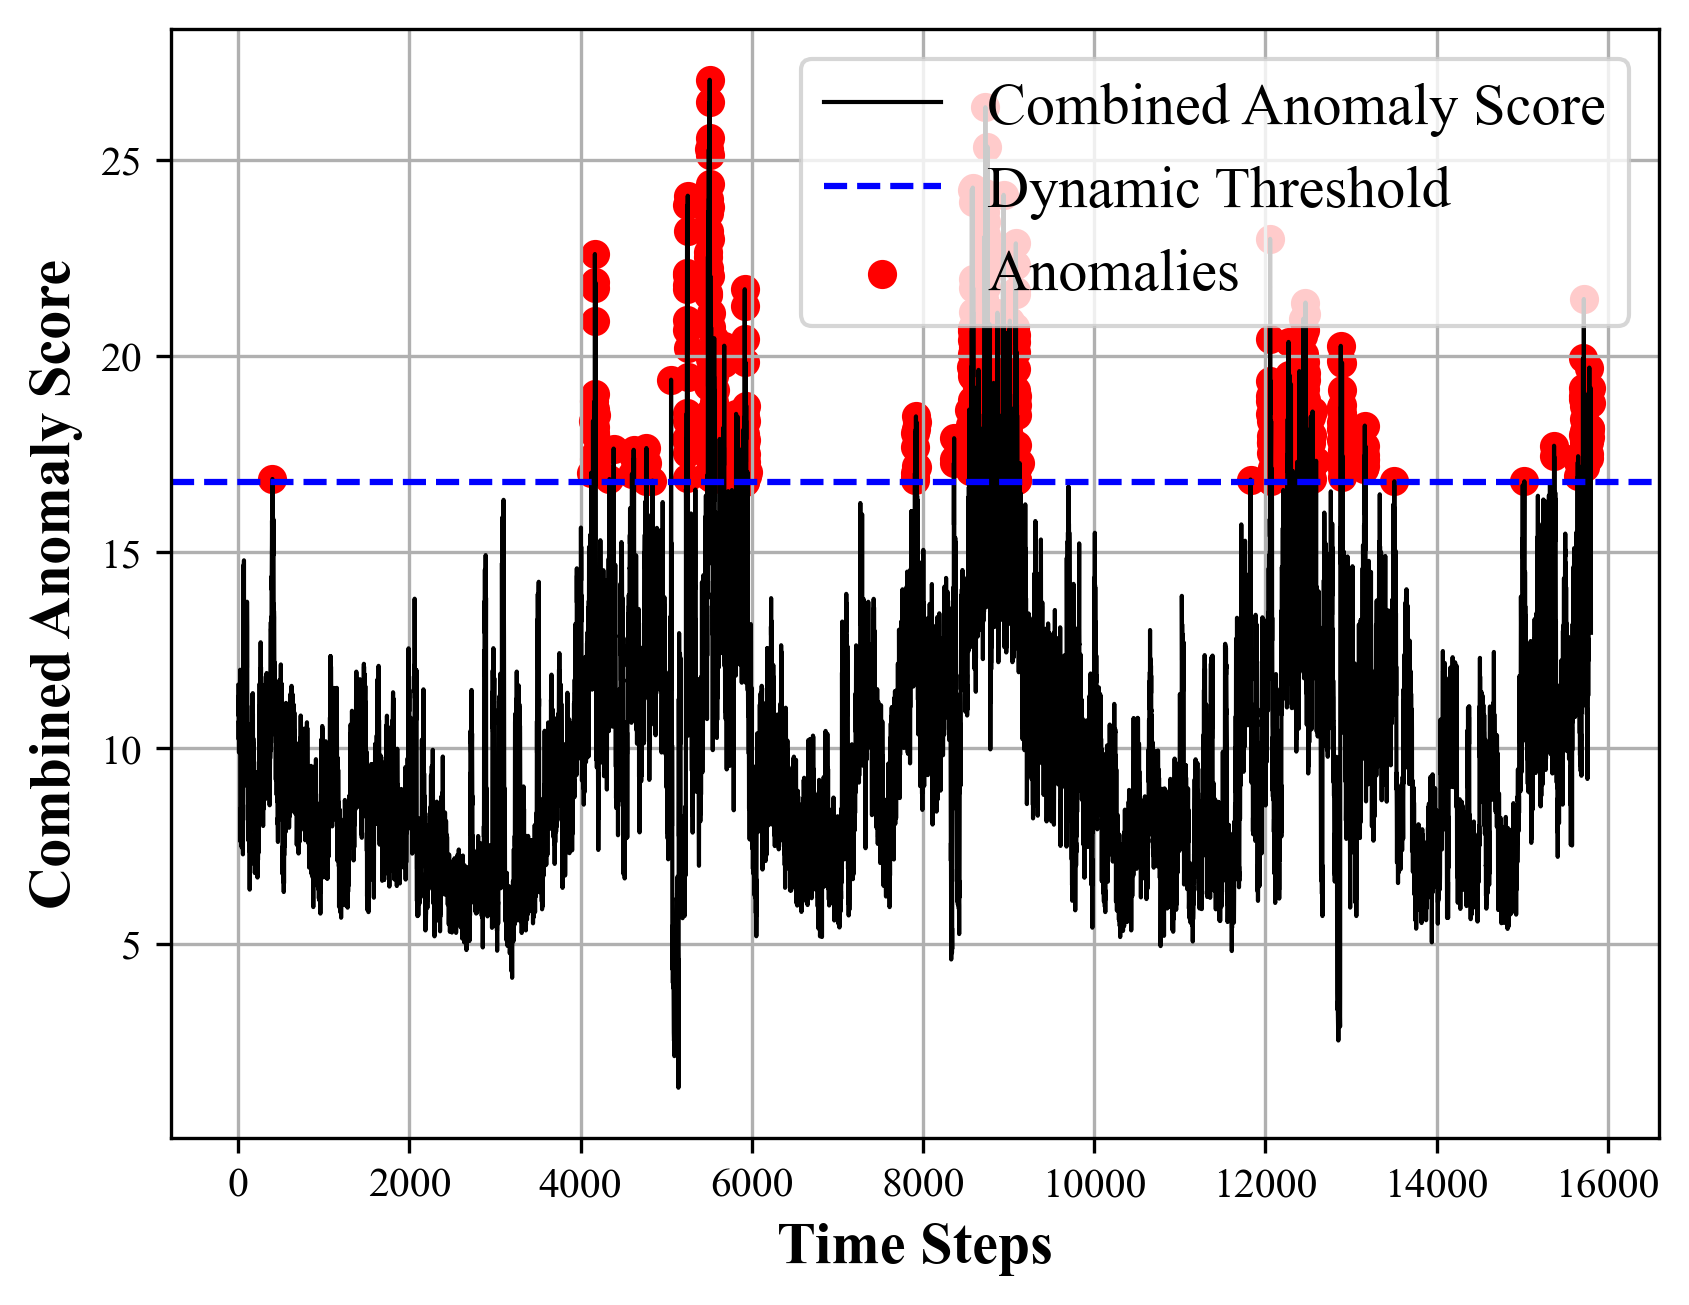

In [105]:
# Truncate the mahalanobis_distances_multivariate array to match the length of test_mae_loss_series
mahalanobis_distances_truncated = mahalanobis_distances_multivariate[:len(test_mae_loss_series)]

# Perform addition
combined_score = test_mae_loss_series.values + mahalanobis_distances_truncated

# Calculate moving average of combined scores
window_size = 24  # Adjust as needed
threshold_multiplier = 2.0
moving_avg = np.convolve(combined_score, np.ones(window_size)/window_size, mode='valid')

# Calculate standard deviation of the moving average
moving_avg_std = np.std(moving_avg)

# Set dynamic threshold as a multiple of the moving average standard deviation
dynamic_threshold = moving_avg[-len(moving_avg)] + threshold_multiplier * moving_avg_std

# Identify anomalies using the dynamic threshold
anomalies_dynamic = (combined_score > dynamic_threshold).astype(int)

# Display the anomalies
print("Number of anomalies (Dynamic Threshold):", np.sum(anomalies_dynamic))

# Ensure test_mae_loss_flat and mahalanobis_distances_flat have compatible shapes
if len(test_mae_loss_flat) != len(mahalanobis_distances_flat):
    min_length = min(len(test_mae_loss_flat), len(mahalanobis_distances_flat))
    test_mae_loss_flat = test_mae_loss_flat[:min_length]
    mahalanobis_distances_flat = mahalanobis_distances_flat[:min_length]

# Calculate combined score
combined_score = test_mae_loss_flat + mahalanobis_distances_flat

# Ensure combined_score and anomalies_dynamic have compatible shapes
if len(combined_score) != len(anomalies_dynamic):
    min_length = min(len(combined_score), len(anomalies_dynamic))
    combined_score = combined_score[:min_length]
    anomalies_dynamic = anomalies_dynamic[:min_length]

# Plot combined anomaly score
plt.figure(dpi=300)
plt.plot(combined_score, label='Combined Anomaly Score', color='k', lw=1)

# Plot dynamic threshold
plt.axhline(y=dynamic_threshold, color='blue', linestyle='--', label='Dynamic Threshold')

# Highlight anomalies
anomaly_indices_dynamic = np.where(anomalies_dynamic == 1)[0]
plt.scatter(anomaly_indices_dynamic, combined_score[anomaly_indices_dynamic], color='red', label='Anomalies')

plt.xlabel('Time Steps', fontweight='bold', fontsize=14)
plt.ylabel('Combined Anomaly Score', fontweight='bold', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [106]:
# Get the timestamps of anomalies
anomaly_timestamps_dynamic = test.index[:len(anomalies_dynamic)][anomalies_dynamic == 1]

# Display the anomalies
print("Timestamps of anomalies (Dynamic Threshold):", anomaly_timestamps_dynamic)


Timestamps of anomalies (Dynamic Threshold): Index(['2016-01-17 18:00:00+00:00', '2016-06-29 15:00:00+00:00',
       '2016-06-30 12:00:00+00:00', '2016-07-01 00:00:00+00:00',
       '2016-07-01 01:00:00+00:00', '2016-07-01 02:00:00+00:00',
       '2016-07-01 04:00:00+00:00', '2016-07-01 07:00:00+00:00',
       '2016-07-01 08:00:00+00:00', '2016-07-01 09:00:00+00:00',
       ...
       '2017-12-03 14:00:00+00:00', '2017-12-03 15:00:00+00:00',
       '2017-12-03 16:00:00+00:00', '2017-12-03 18:00:00+00:00',
       '2017-12-03 20:00:00+00:00', '2017-12-03 22:00:00+00:00',
       '2017-12-04 00:00:00+00:00', '2017-12-04 02:00:00+00:00',
       '2017-12-04 04:00:00+00:00', '2017-12-04 06:00:00+00:00'],
      dtype='object', name='Timestamp', length=596)


In [107]:
len(anomaly_timestamps_dynamic)

596

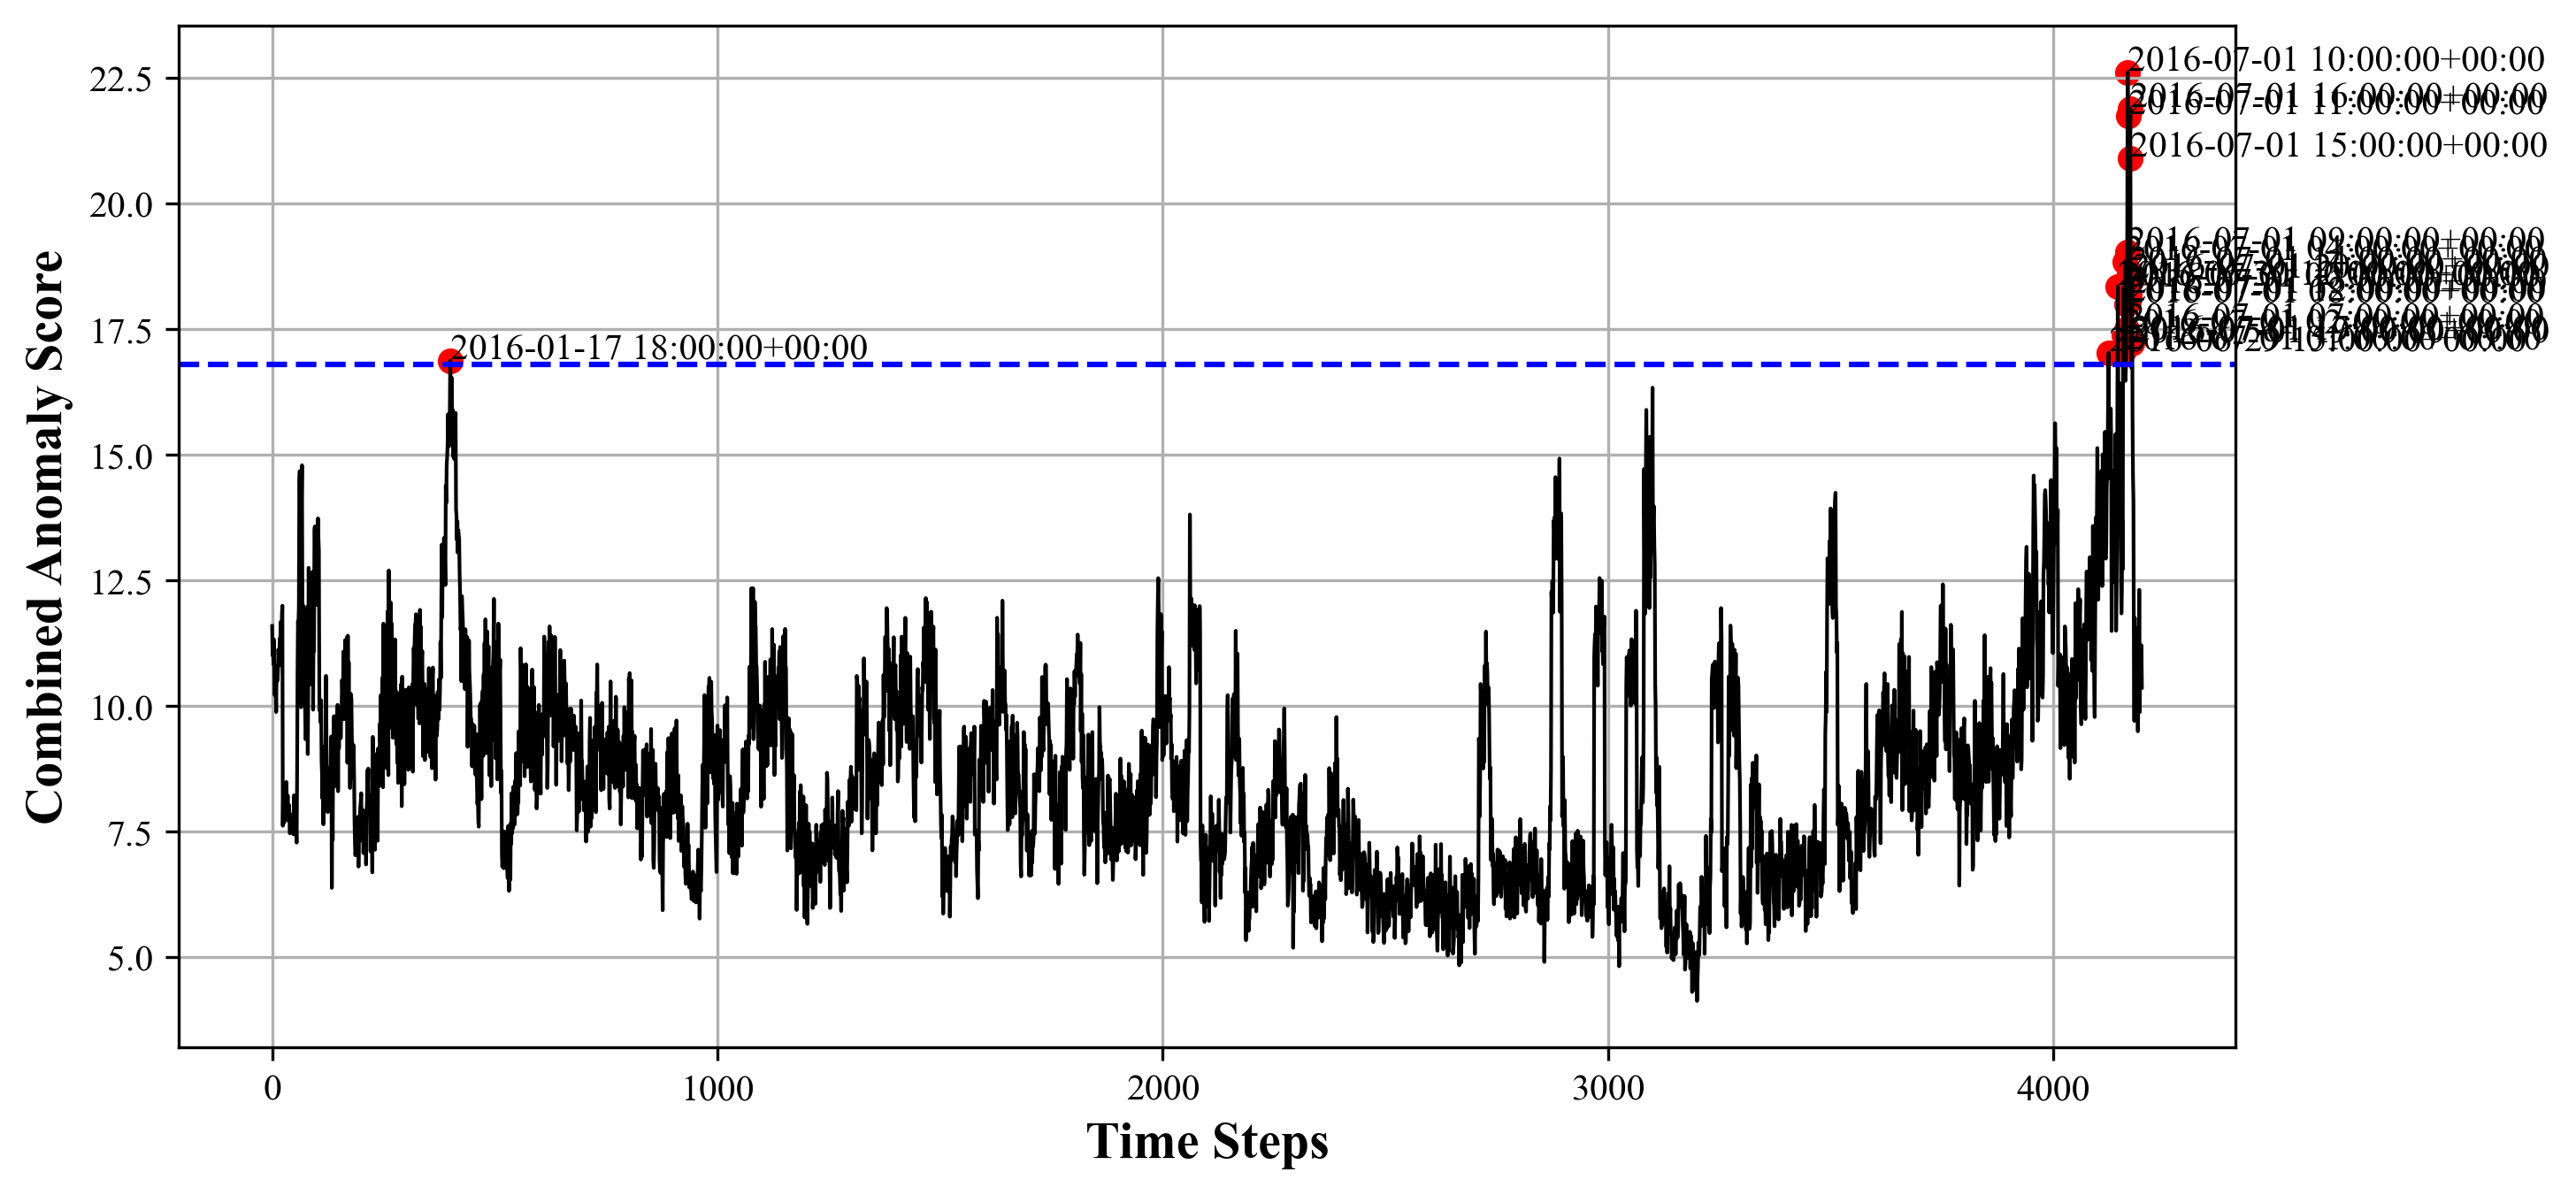

In [116]:
# Define the subset size
subset_size = 4200

# Plot combined anomaly score for the subset
plt.figure(dpi=300, figsize=(10,5))
plt.plot(combined_score[:subset_size], label='Combined Anomaly Score', color='k', lw=1)

# Plot dynamic threshold
plt.axhline(y=dynamic_threshold, color='blue', linestyle='--', label='Dynamic Threshold')

# Highlight anomalies
anomaly_indices_dynamic_subset = anomaly_indices_dynamic[anomaly_indices_dynamic < subset_size]
plt.scatter(anomaly_indices_dynamic_subset, combined_score[anomaly_indices_dynamic_subset], color='red', label='Anomalies')

# Annotate timestamps for anomalies in the subset
for anomaly_index in anomaly_indices_dynamic_subset:
    anomaly_timestamp = test.index[anomaly_index]
    plt.annotate(anomaly_timestamp, 
                 xy=(anomaly_index, combined_score[anomaly_index]), 
                 xytext=(anomaly_index, combined_score[anomaly_index] + 0.05),
                 )

plt.xlabel('Time Steps', fontweight='bold', fontsize=14)
plt.ylabel('Combined Anomaly Score', fontweight='bold', fontsize=14)

# # Set legend in the middle
# plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)

plt.show()


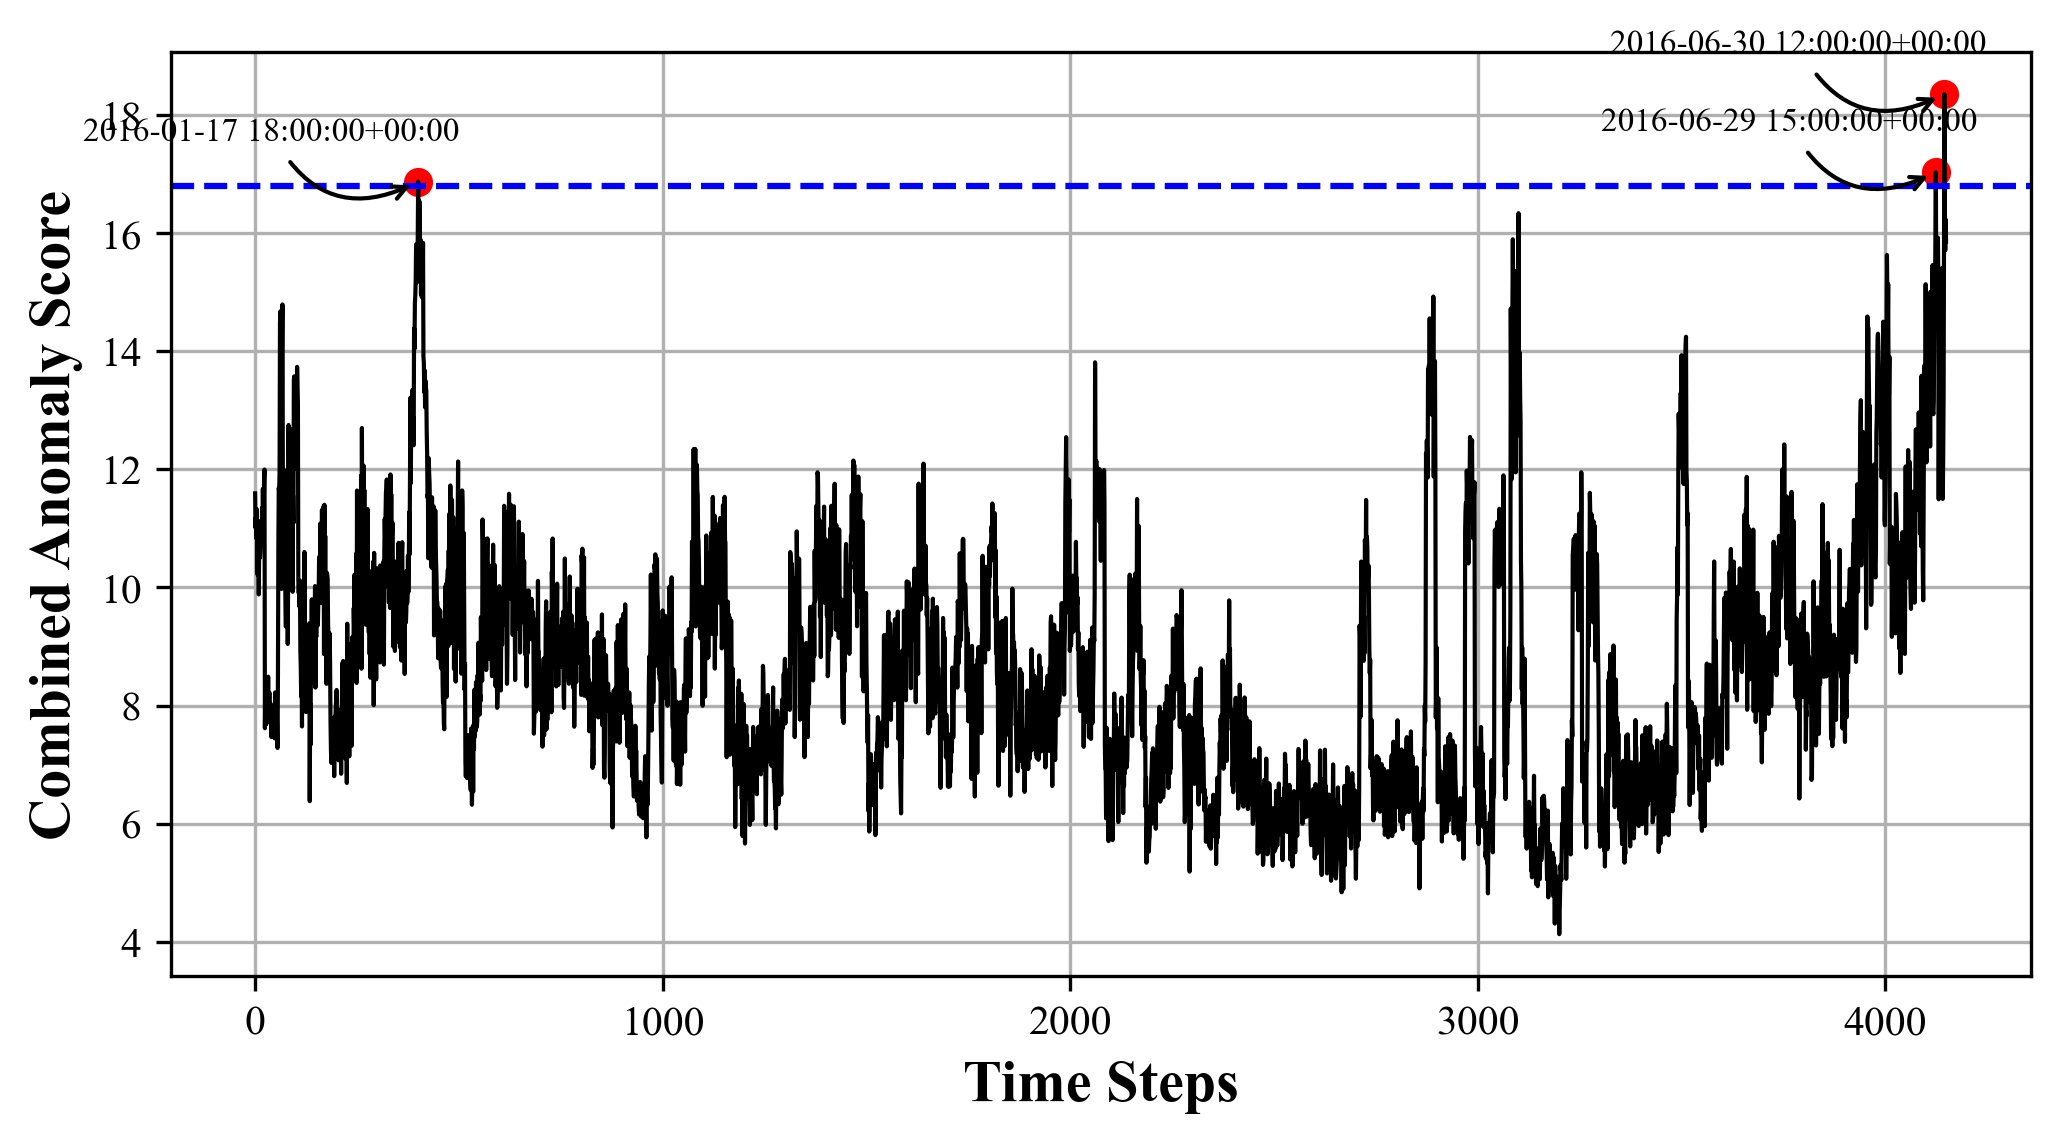

In [126]:
# Define the subset size
subset_size = 4150

# Plot combined anomaly score for the subset
plt.figure(dpi=300, figsize=(8,4))
plt.plot(combined_score[:subset_size], label='Combined Anomaly Score', color='k', lw=1)

# Plot dynamic threshold
plt.axhline(y=dynamic_threshold, color='blue', linestyle='--', label='Dynamic Threshold')

# Highlight anomalies
anomaly_indices_dynamic_subset = anomaly_indices_dynamic[anomaly_indices_dynamic < subset_size]
plt.scatter(anomaly_indices_dynamic_subset, combined_score[anomaly_indices_dynamic_subset], color='red', label='Anomalies')

# Annotate timestamps for anomalies in the subset
for anomaly_index in anomaly_indices_dynamic_subset:
    anomaly_timestamp = test.index[anomaly_index]
    plt.annotate(anomaly_timestamp, 
                 xy=(anomaly_index, combined_score[anomaly_index]), 
#                  rotation=45,  # Rotate the timestamp for better visibility
                 ha='right',  # Align the text to the right
                 fontsize=8,  # Adjust fontsize for better readability
                 textcoords="offset points",  # Offset annotation position
                 xytext=(10,10),  # Offset annotation position by 10 points in both x and y directions
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5", color='black'))  # Add arrow pointing to the annotated point

plt.xlabel('Time Steps', fontweight='bold', fontsize=14)
plt.ylabel('Combined Anomaly Score', fontweight='bold', fontsize=14)

# # Set legend in the middle
# plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)

plt.show()


